# Tensor Flow Notebook
## W207 Final Project
### T. P. Goter
### July 6, 2019

This workbook is used to create, fit and analyze various neural networks for facial keypoint detection.

In [ ]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
tf.__version__

'2.0.0-beta1'

## Data Loading

- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb. 
- This dataset has the NaNs removed and a few mislabeled images removed as well. 
- As such there is only limited training and development data to use. 
- The image data has already been normalized to [0,1]

In [224]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle("df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])


## Baseline Neural Net
CNNs are combinations of convolution layers, pooling layers and dropout layers followed by one or two fully connected layers once the number of dimensions has been sufficiently reduced.

1. Let's include just one hidden layer and one output layer
2. The input layer will reduce our flattened 96x96 matrix (i.e., 9216 in length) to a predetermined number of hidden units
3. We will then run sensitivities to # of hidden units, activation, optimizer, and learning rate
4. We will judge our model based on RMSE error and run time.

In [225]:
def base_model(hidden_units=100, activation='relu'):
    base_model = models.Sequential()
    base_model.add(layers.Dense(hidden_units,activation=activation, kernel_initializer='uniform',input_shape=[9216]))
    base_model.add(layers.Dense(30, activation=activation))
    base_model.build()
    print(base_model.summary())
    return base_model
   
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [230]:
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
nadam = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

opt_list = [adam, sgd, nadam, adagrad]

In [232]:
base_model_results = {}
for hidden_unit in [50, 100, 150, 200]:
    for act in ['relu', 'sigmoid', 'tanh']:
        for opt in opt_list:
            model = base_model(hidden_units=hidden_unit, activation='relu')
            model.compile(optimizer=opt,
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            time_callback = TimeHistory()
            history = model.fit(X, y, epochs=400, validation_split=0.15, callbacks=[time_callback])
            times = time_callback.times

            # Convert to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times

            base_model_results[(hidden_unit, act, opt)] = hist

            filename = "base_model_{}_{}".format(hidden_unit, act)
            with open("Models/"+filename+".json", 'w') as jsonfile:
                jsonfile.write(model.to_json())
            model.save_weights("Models/"+filename+".h5")

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 50)                460850    
_________________________________________________________________
dense_54 (Dense)             (None, 30)                1530      
Total params: 462,380
Trainable params: 462,380
Non-trainable params: 0
_________________________________________________________________
None
Train on 1567 samples, validate on 277 samples
Epoch 1/400
1567/1567 [==============================] - 0s 201us/sample - loss: 1685.9116 - mean_squared_error: 1685.9120 - val_loss: 1194.4207 - val_mean_squared_error: 1194.4207
Epoch 2/400
1567/1567 [==============================] - 0s 122us/sample - loss: 1099.4268 - mean_squared_error: 1099.4266 - val_loss: 1104.9893 - val_mean_squared_error: 1104.9893
Epoch 3/400
1567/1567 [==============================] - 0s 121us/sample - loss: 1086.9985 - me

1567/1567 [==============================] - 0s 114us/sample - loss: 1040.0506 - mean_squared_error: 1040.0507 - val_loss: 1049.6578 - val_mean_squared_error: 1049.6578
Epoch 43/400
1567/1567 [==============================] - 0s 116us/sample - loss: 1039.5007 - mean_squared_error: 1039.5009 - val_loss: 1063.7966 - val_mean_squared_error: 1063.7965
Epoch 44/400
1567/1567 [==============================] - 0s 105us/sample - loss: 1040.6663 - mean_squared_error: 1040.6665 - val_loss: 1052.0084 - val_mean_squared_error: 1052.0083
Epoch 45/400
1567/1567 [==============================] - 0s 106us/sample - loss: 1038.9872 - mean_squared_error: 1038.9872 - val_loss: 1052.5993 - val_mean_squared_error: 1052.5992
Epoch 46/400
1567/1567 [==============================] - 0s 108us/sample - loss: 1038.4525 - mean_squared_error: 1038.4525 - val_loss: 1048.8402 - val_mean_squared_error: 1048.8402
Epoch 47/400
1567/1567 [==============================] - 0s 112us/sample - loss: 1037.6912 - mean_squa

1567/1567 [==============================] - 0s 113us/sample - loss: 1028.6790 - mean_squared_error: 1028.6787 - val_loss: 1042.7136 - val_mean_squared_error: 1042.7135
Epoch 88/400
1567/1567 [==============================] - 0s 104us/sample - loss: 1031.8772 - mean_squared_error: 1031.8772 - val_loss: 1044.2915 - val_mean_squared_error: 1044.2914
Epoch 89/400
1567/1567 [==============================] - 0s 106us/sample - loss: 1028.4828 - mean_squared_error: 1028.4827 - val_loss: 1041.9312 - val_mean_squared_error: 1041.9312
Epoch 90/400
1567/1567 [==============================] - 0s 106us/sample - loss: 1028.8015 - mean_squared_error: 1028.8014 - val_loss: 1042.9285 - val_mean_squared_error: 1042.9285
Epoch 91/400
1567/1567 [==============================] - 0s 106us/sample - loss: 1028.9764 - mean_squared_error: 1028.9764 - val_loss: 1041.5982 - val_mean_squared_error: 1041.5981
Epoch 92/400
1567/1567 [==============================] - 0s 107us/sample - loss: 1027.3561 - mean_squa

Epoch 132/400
1567/1567 [==============================] - 0s 111us/sample - loss: 1024.7968 - mean_squared_error: 1024.7968 - val_loss: 1038.5560 - val_mean_squared_error: 1038.5560
Epoch 133/400
1567/1567 [==============================] - 0s 115us/sample - loss: 1027.5835 - mean_squared_error: 1027.5833 - val_loss: 1054.9624 - val_mean_squared_error: 1054.9623
Epoch 134/400
1567/1567 [==============================] - 0s 113us/sample - loss: 1026.0063 - mean_squared_error: 1026.0063 - val_loss: 1037.9546 - val_mean_squared_error: 1037.9546
Epoch 135/400
1567/1567 [==============================] - 0s 114us/sample - loss: 1024.5364 - mean_squared_error: 1024.5364 - val_loss: 1038.3915 - val_mean_squared_error: 1038.3916
Epoch 136/400
1567/1567 [==============================] - 0s 105us/sample - loss: 1026.2795 - mean_squared_error: 1026.2795 - val_loss: 1038.0769 - val_mean_squared_error: 1038.0768
Epoch 137/400
1567/1567 [==============================] - 0s 108us/sample - loss: 10

Epoch 177/400
1567/1567 [==============================] - 0s 110us/sample - loss: 1024.3666 - mean_squared_error: 1024.3665 - val_loss: 1038.7039 - val_mean_squared_error: 1038.7040
Epoch 178/400
1567/1567 [==============================] - 0s 107us/sample - loss: 1023.9227 - mean_squared_error: 1023.9228 - val_loss: 1035.2473 - val_mean_squared_error: 1035.2474
Epoch 179/400
1567/1567 [==============================] - 0s 104us/sample - loss: 1022.8751 - mean_squared_error: 1022.8749 - val_loss: 1035.3189 - val_mean_squared_error: 1035.3191
Epoch 180/400
1567/1567 [==============================] - 0s 115us/sample - loss: 1023.0650 - mean_squared_error: 1023.0649 - val_loss: 1035.3206 - val_mean_squared_error: 1035.3207
Epoch 181/400
1567/1567 [==============================] - 0s 109us/sample - loss: 1022.8955 - mean_squared_error: 1022.8954 - val_loss: 1035.9781 - val_mean_squared_error: 1035.9780
Epoch 182/400
1567/1567 [==============================] - 0s 112us/sample - loss: 10

Epoch 222/400
1567/1567 [==============================] - 0s 111us/sample - loss: 1022.2849 - mean_squared_error: 1022.2849 - val_loss: 1033.2618 - val_mean_squared_error: 1033.2620
Epoch 223/400
1567/1567 [==============================] - 0s 107us/sample - loss: 1023.1847 - mean_squared_error: 1023.1848 - val_loss: 1036.6015 - val_mean_squared_error: 1036.6017
Epoch 224/400
1567/1567 [==============================] - 0s 106us/sample - loss: 1024.7263 - mean_squared_error: 1024.7264 - val_loss: 1033.0405 - val_mean_squared_error: 1033.0405
Epoch 225/400
1567/1567 [==============================] - 0s 114us/sample - loss: 1022.5472 - mean_squared_error: 1022.5470 - val_loss: 1035.6674 - val_mean_squared_error: 1035.6674
Epoch 226/400
1567/1567 [==============================] - 0s 117us/sample - loss: 1023.2337 - mean_squared_error: 1023.2336 - val_loss: 1033.3006 - val_mean_squared_error: 1033.3007
Epoch 227/400
1567/1567 [==============================] - 0s 124us/sample - loss: 10

Epoch 267/400
1567/1567 [==============================] - 0s 116us/sample - loss: 1022.2832 - mean_squared_error: 1022.2831 - val_loss: 1031.8052 - val_mean_squared_error: 1031.8052
Epoch 268/400
1567/1567 [==============================] - 0s 116us/sample - loss: 1022.0380 - mean_squared_error: 1022.0379 - val_loss: 1031.5472 - val_mean_squared_error: 1031.5471
Epoch 269/400
1567/1567 [==============================] - 0s 111us/sample - loss: 1021.7609 - mean_squared_error: 1021.7609 - val_loss: 1031.5706 - val_mean_squared_error: 1031.5707
Epoch 270/400
1567/1567 [==============================] - 0s 112us/sample - loss: 1021.9750 - mean_squared_error: 1021.9749 - val_loss: 1031.8449 - val_mean_squared_error: 1031.8448
Epoch 271/400
1567/1567 [==============================] - 0s 108us/sample - loss: 1022.1922 - mean_squared_error: 1022.1920 - val_loss: 1033.9191 - val_mean_squared_error: 1033.9189
Epoch 272/400
1567/1567 [==============================] - 0s 107us/sample - loss: 10

Epoch 312/400
1567/1567 [==============================] - 0s 112us/sample - loss: 1021.6872 - mean_squared_error: 1021.6871 - val_loss: 1033.2988 - val_mean_squared_error: 1033.2988
Epoch 313/400
1567/1567 [==============================] - 0s 108us/sample - loss: 1022.2452 - mean_squared_error: 1022.2454 - val_loss: 1030.6376 - val_mean_squared_error: 1030.6377
Epoch 314/400
1567/1567 [==============================] - 0s 105us/sample - loss: 1021.5710 - mean_squared_error: 1021.5709 - val_loss: 1030.9613 - val_mean_squared_error: 1030.9612
Epoch 315/400
1567/1567 [==============================] - 0s 109us/sample - loss: 1021.6186 - mean_squared_error: 1021.6185 - val_loss: 1030.6384 - val_mean_squared_error: 1030.6383
Epoch 316/400
1567/1567 [==============================] - 0s 116us/sample - loss: 1021.7761 - mean_squared_error: 1021.7762 - val_loss: 1030.7510 - val_mean_squared_error: 1030.7511
Epoch 317/400
1567/1567 [==============================] - 0s 117us/sample - loss: 10

Epoch 357/400
1567/1567 [==============================] - 0s 115us/sample - loss: 1021.4888 - mean_squared_error: 1021.4890 - val_loss: 1030.1291 - val_mean_squared_error: 1030.1290
Epoch 358/400
1567/1567 [==============================] - 0s 110us/sample - loss: 1021.5556 - mean_squared_error: 1021.5556 - val_loss: 1030.7857 - val_mean_squared_error: 1030.7856
Epoch 359/400
1567/1567 [==============================] - 0s 113us/sample - loss: 1021.4592 - mean_squared_error: 1021.4592 - val_loss: 1030.0068 - val_mean_squared_error: 1030.0068
Epoch 360/400
1567/1567 [==============================] - 0s 115us/sample - loss: 1021.6143 - mean_squared_error: 1021.6143 - val_loss: 1029.9803 - val_mean_squared_error: 1029.9803
Epoch 361/400
1567/1567 [==============================] - 0s 112us/sample - loss: 1021.5814 - mean_squared_error: 1021.5814 - val_loss: 1029.7840 - val_mean_squared_error: 1029.7839
Epoch 362/400
1567/1567 [==============================] - 0s 116us/sample - loss: 10

KeyboardInterrupt: 

Text(0.5, 0.9, 'Performance Comparison for Single Layer, Fully Connected Neural Nets')

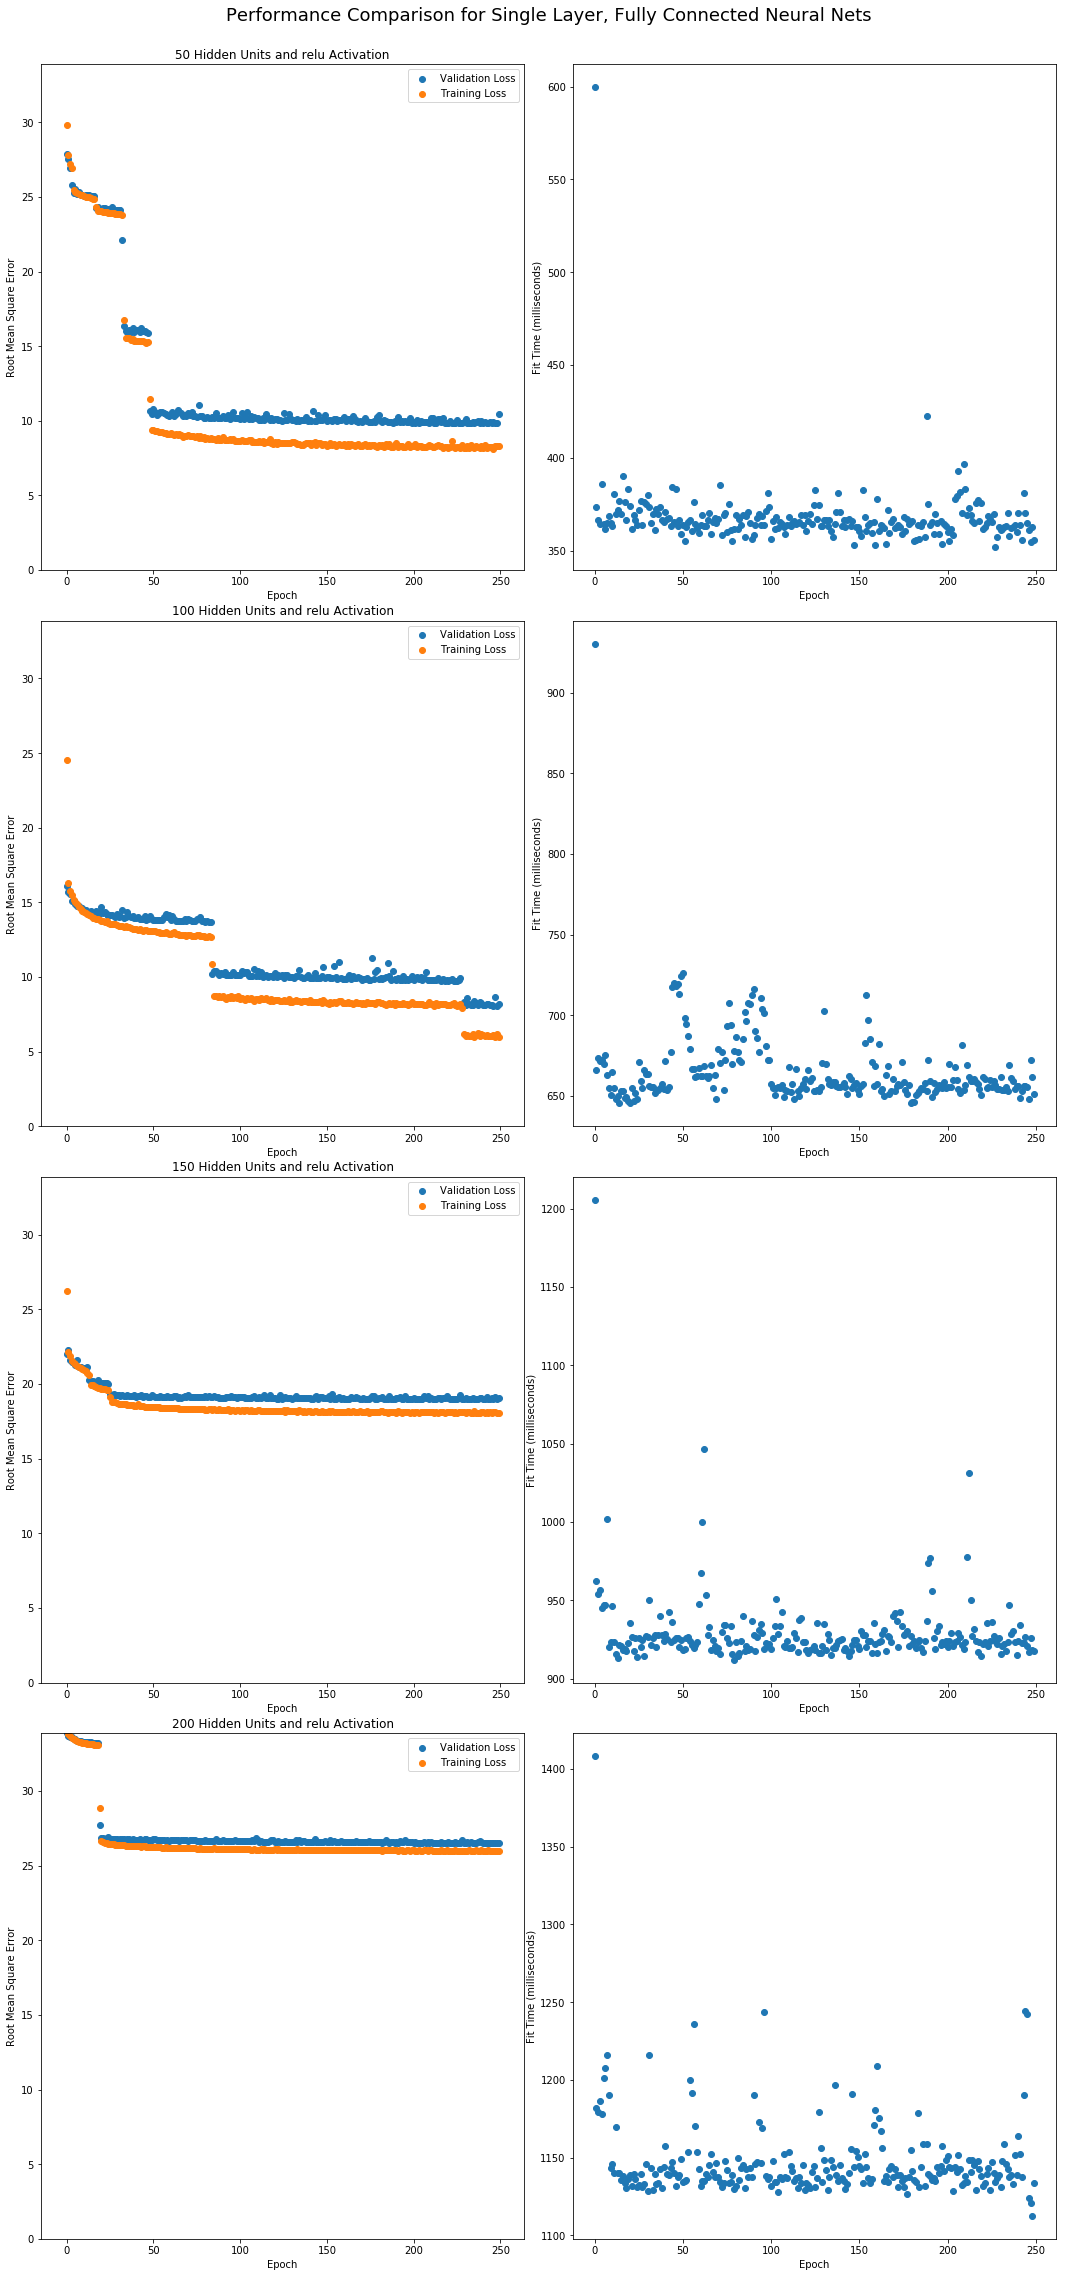

In [223]:
base_model_results[(200,'relu')].tail()

fig, axes = plt.subplots(len(base_model_results), 2, figsize=(15, len(base_model_results)*10))
for i, (key, value) in enumerate(base_model_results.items()):
    axes[i,0].scatter(value.epoch, value.val_RMSE, label='Validation Loss')
    axes[i,0].scatter(value.epoch, value.RMSE, label='Training Loss')
    axes[i,1].scatter(value.epoch, value.times*1000, label='Fit Time')
    axes[i,0].set_xlabel('Epoch')
    axes[i,0].set_ylabel('Root Mean Square Error')
    axes[i,1].set_xlabel('Epoch')
    axes[i,1].set_ylabel('Fit Time (milliseconds)')
    axes[i,0].set_ylim([0,hist.val_RMSE.max()])
    axes[i,0].legend()
    axes[i,0].set_title("{} Hidden Units and {} Activation".format(key[0], key[1]))
    
# Adjust the spacing of the subplots
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.1, wspace=0.1)

# Add an overarching title for these plots
fig.suptitle("Performance Comparison for Single Layer, Fully Connected Neural Nets",
             fontsize=18, y=0.90)


         loss  mean_squared_error    val_loss  val_mean_squared_error  epoch  \
0  637.228267          637.228210  492.983026              492.983032      0   
1  493.416352          493.416290  480.166259              480.166290      1   
2  479.926890          479.926971  469.270008              469.269989      2   
3  471.881918          471.881866  464.302449              464.302429      3   
4  467.636092          467.636078  461.519876              461.519836      4   

        RMSE   val_RMSE  
0  25.243380  22.203221  
1  22.212976  21.912697  
2  21.907236  21.662640  
3  21.722842  21.547678  
4  21.624895  21.483013  


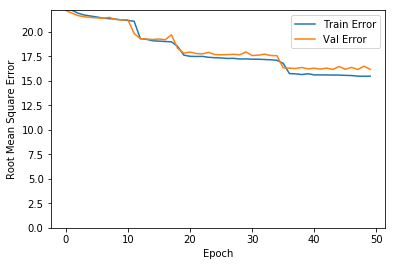

In [203]:
plot_history(history)

In [205]:
len(times)

50

In [191]:
model.predict(train_X[0:2])

array([[68.588394, 39.292473, 31.572193, 38.81867 , 61.754864, 40.100616,
        74.44067 , 39.395607, 38.13831 ,  0.      , 24.760841,  0.      ,
        58.765293, 32.016537, 81.26625 , 32.188618, 41.16877 ,  0.      ,
         0.      , 31.483452, 48.399982, 63.54024 , 64.48226 , 79.628426,
        33.858856, 78.34169 , 48.271717, 76.584946, 48.89725 , 86.05743 ],
       [70.393845, 40.595383, 31.115082, 38.873463, 62.401283, 41.92533 ,
        77.88759 , 41.930996, 37.63399 ,  0.      , 23.901354,  0.      ,
        58.56992 , 32.614647, 84.57923 , 33.23419 , 40.77044 ,  0.      ,
         0.      , 30.777077, 48.237175, 64.022606, 63.743614, 86.39019 ,
        34.907547, 84.66972 , 48.420155, 81.94794 , 48.42233 , 92.67551 ]],
      dtype=float32)